In [2]:
import sionna
import tensorflow as tf
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sionna.mapping import Constellation, Mapper, Demapper
from sionna.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder, LDPCBPDecoder
from sionna.fec.interleaving import RowColumnInterleaver, Deinterleaver, RandomInterleaver
from sionna.fec.scrambling import Scrambler, Descrambler
from sionna.fec.utils import GaussianPriorSource, load_parity_check_examples, get_exit_analytic, plot_exit_chart, plot_trajectory
from sionna.utils import BinarySource, ebnodb2no, hard_decisions
from sionna.utils.plotting import PlotBER
from sionna.channel import AWGN

sionna.config.seed=42

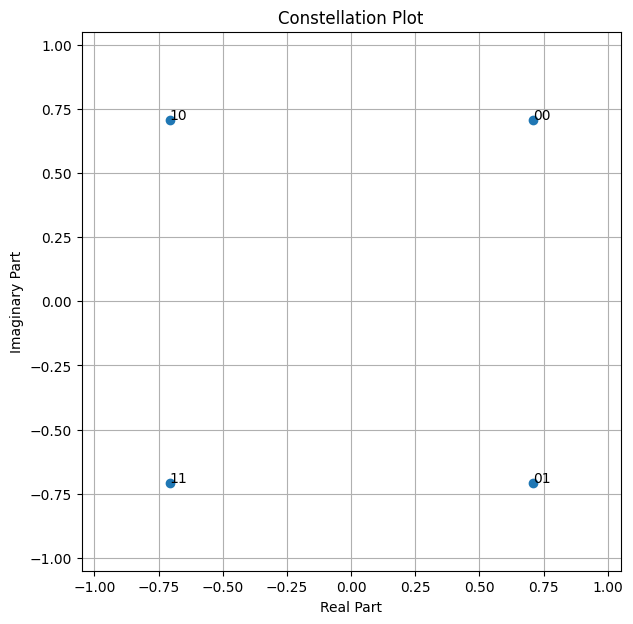

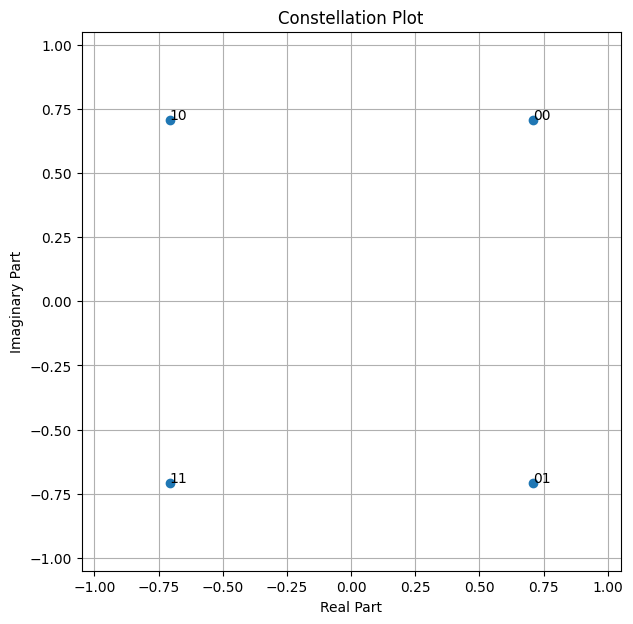

In [4]:
constellation = Constellation('qam', num_bits_per_symbol=2)
constellation.show()

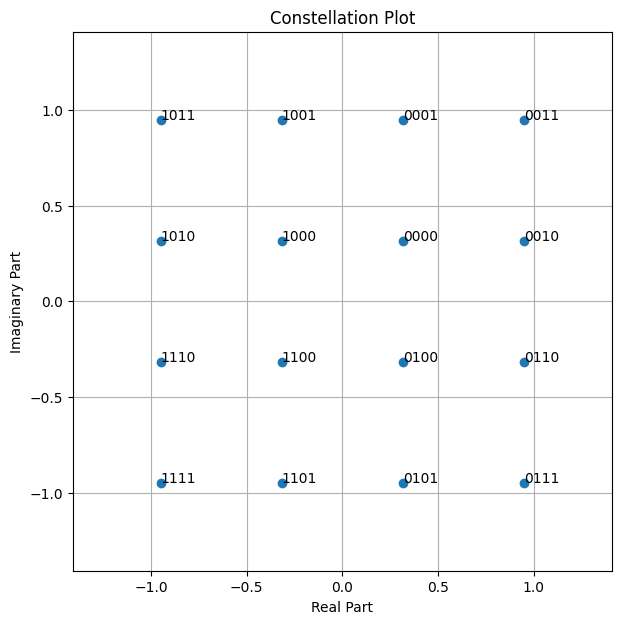

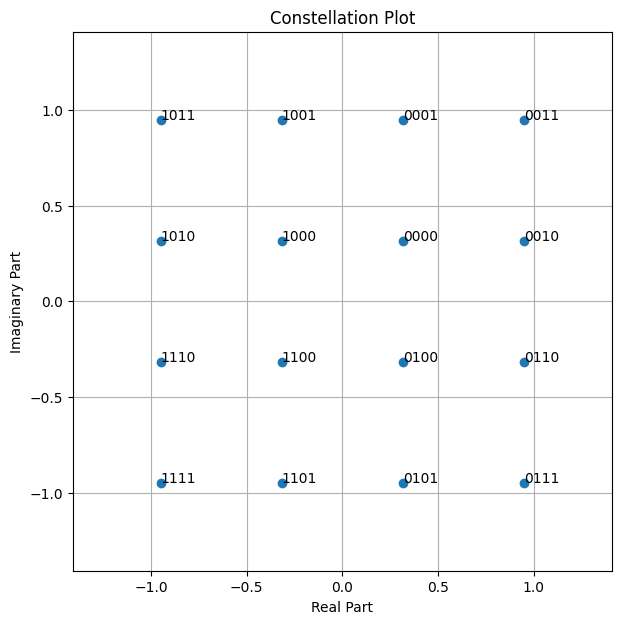

In [5]:
constellation = Constellation('qam', num_bits_per_symbol=4) #16 QAM
constellation.show()

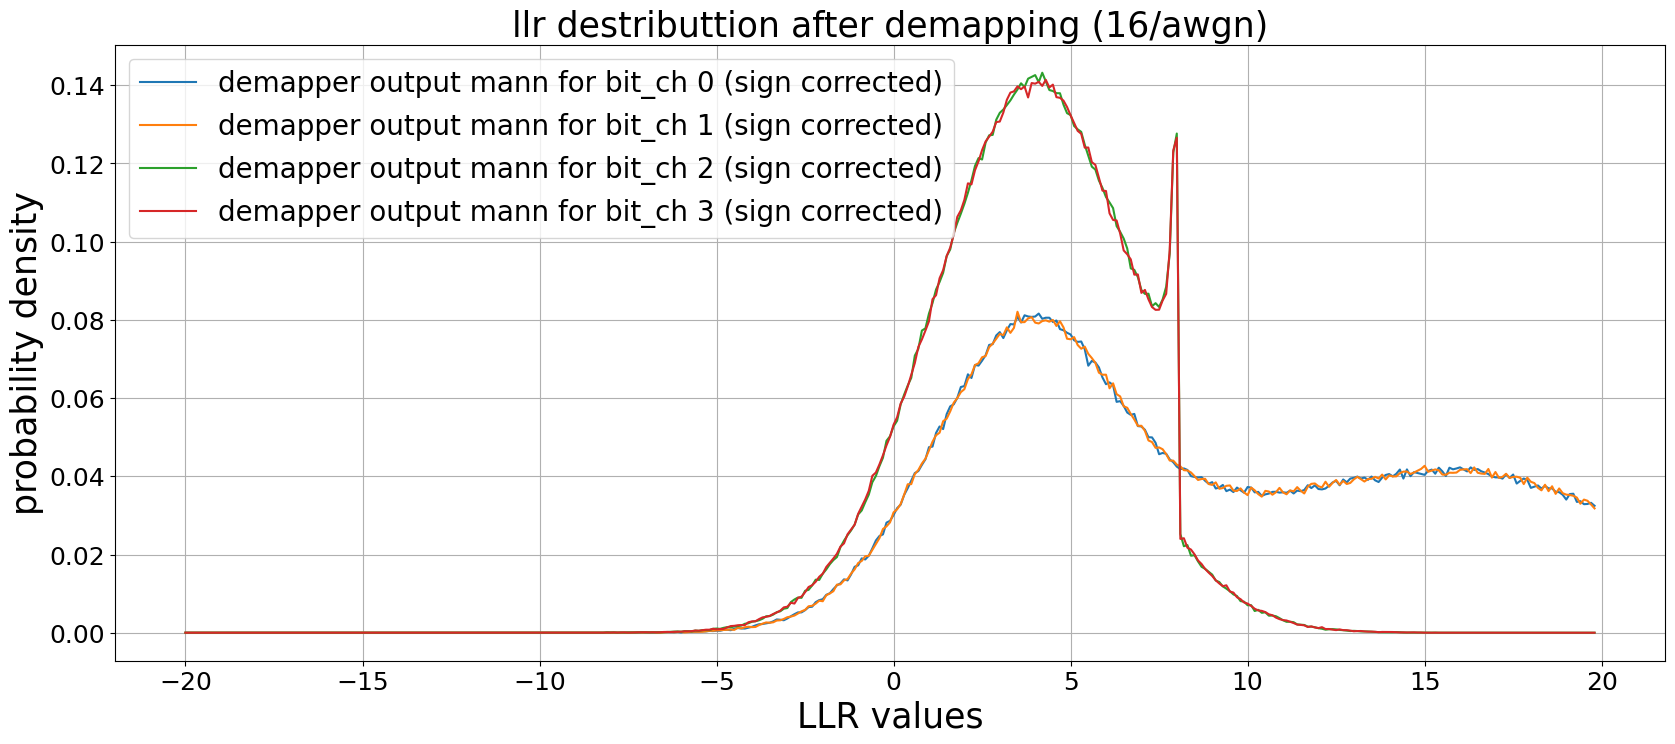

In [6]:
batch_size = int(1e6)
num_bits_per_symbol = 4
ebno_db = 4
source = BinarySource()
channel = AWGN()
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate=1)
llr_bins = np.arange(-20, 20, 0.1)
constellation = Constellation('qam', num_bits_per_symbol=num_bits_per_symbol)
mapper = Mapper(constellation=constellation)
demapper = Demapper('app', constellation=constellation)
b = source([batch_size, num_bits_per_symbol])
x = mapper(b)
y = channel([x, no])
llr = demapper([y, no])
#now flip the sign 
llr_b = tf.multiply(llr, (2.*b-1.))

# llr distribution for all bit channels individually 
llr_dist = []
for i in range(num_bits_per_symbol):
    llr_np = tf.reshape(llr_b[:,i], [-1]).numpy()
    t, _ = np.histogram(llr_np, bins=llr_bins, density=True)
    llr_dist.append(t)

#plotting llr VS probability densoty 
plt.figure(figsize=(20,8))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='both')
plt.xlabel('LLR values', fontsize=25)
plt.ylabel('probability density', fontsize=25)
for idx, llr_hist in enumerate(llr_dist):
    leg_str = f'demapper output mann for bit_ch {idx} (sign corrected)'.format()
    plt.plot(llr_bins[:-1], llr_hist, label = leg_str)
plt.title('llr destributtion after demapping (16/awgn)', fontsize=25)
plt.legend(fontsize=20)

it position in **16-QAM**.
- **Probability density** shows how LLR values are spread across different bit channels.

---

## **🔑 Summary**
### **1️⃣ What Does This Code Do?**
- Simulates a **BICM transmission** with **16-QAM over an AWGN channel**.
- Computes **soft-demapped LLR values**.
- Analyzes the **distribution of LLR values** for different bit positions.

### **2️⃣ Why Is This Important in 5G?**
✅ **LLR-based soft decoding** improves **error correction** (e.g., LDPC, Polar Codes).  
✅ **Higher-order modulations** (16-QAM, 64-QAM) require **accurate LLR computation**.  
✅ **Understanding LLR distributions** helps in **adaptive coding & modulation (AMC)**.  

🚀 **This approach is used in 5G NR for robust, high-speed wireless communication.**

In [7]:
# bitwise BER's 
b_hat = hard_decisions(llr)
errors = tf.cast(tf.not_equal(b, b_hat), tf.float32)
ber_per_bit = tf.reduce_mean(errors, axis=0)
print('ber per bit-channel: ', ber_per_bit.numpy())

ber per bit-channel:  [0.039031 0.038787 0.077408 0.078288]


### SIMPLE BER SIMULATIONS 

In [8]:
# generate new figure
ber_plot_allzero = PlotBER("BER Performance of All-zero Codeword Simulations")

# and define baseline
num_bits_per_symbol = 2 # QPSK
num_bp_iter = 20 # number of decoder iterations

# LDPC code parameters
k = 600 # number of information bits per codeword
n = 1200 # number of codeword bits

# and the initialize the LDPC encoder / decoder
encoder = LDPC5GEncoder(k, n)
decoder = LDPC5GDecoder(encoder, # connect encoder (for shared code parameters)
                        cn_type="boxplus-phi", # use the exact boxplus function
                        num_iter=num_bp_iter)

# initialize a random interleaver and corresponding deinterleaver
interleaver = RandomInterleaver()
deinterleaver = Deinterleaver(interleaver)

# mapper and demapper
constellation = Constellation("qam", num_bits_per_symbol=num_bits_per_symbol)
mapper = Mapper(constellation=constellation)
demapper = Demapper("app", constellation=constellation) # APP demapper

# define system
@tf.function() # we enable graph mode for faster simulations
def run_ber(batch_size, ebno_db):
    # calculate noise variance
    no = ebnodb2no(ebno_db,
                   num_bits_per_symbol=num_bits_per_symbol,
                   coderate=k/n)
    u = source([batch_size, k]) # generate random bit sequence to transmit
    c = encoder(u) # LDPC encode (incl. rate-matching and CRC concatenation)
    c_int = interleaver(c)
    x = mapper(c_int) # map to symbol (QPSK)
    y = channel([x, no]) # transmit over AWGN channel
    llr_ch = demapper([y, no]) # demapp
    llr_deint = deinterleaver(llr_ch)
    u_hat = decoder(llr_deint) # run LDPC decoder (incl. de-rate-matching)

    return u, u_hat

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.6478e-01 | 9.9900e-01 |       98871 |      600000 |          999 |        1000 |         5.4 |reached target bit errors
     0.25 | 1.3726e-01 | 9.8800e-01 |       82358 |      600000 |          988 |        1000 |         1.9 |reached target bit errors
      0.5 | 1.0939e-01 | 9.5600e-01 |       65634 |      600000 |          956 |        1000 |         1.9 |reached target bit errors
     0.75 | 6.8037e-02 | 7.6900e-01 |       40822 |      600000 |          769 |        1000 |         1.9 |reached target bit errors
      1.0 | 2.8460e-02 | 4.7400e-01 |       17076 |      600000 |          474 |        1000 |         2.0 |reached target bit errors
     1.25 | 9.6083e-03 | 1.9900e-01 |        5765 |      600000 |          

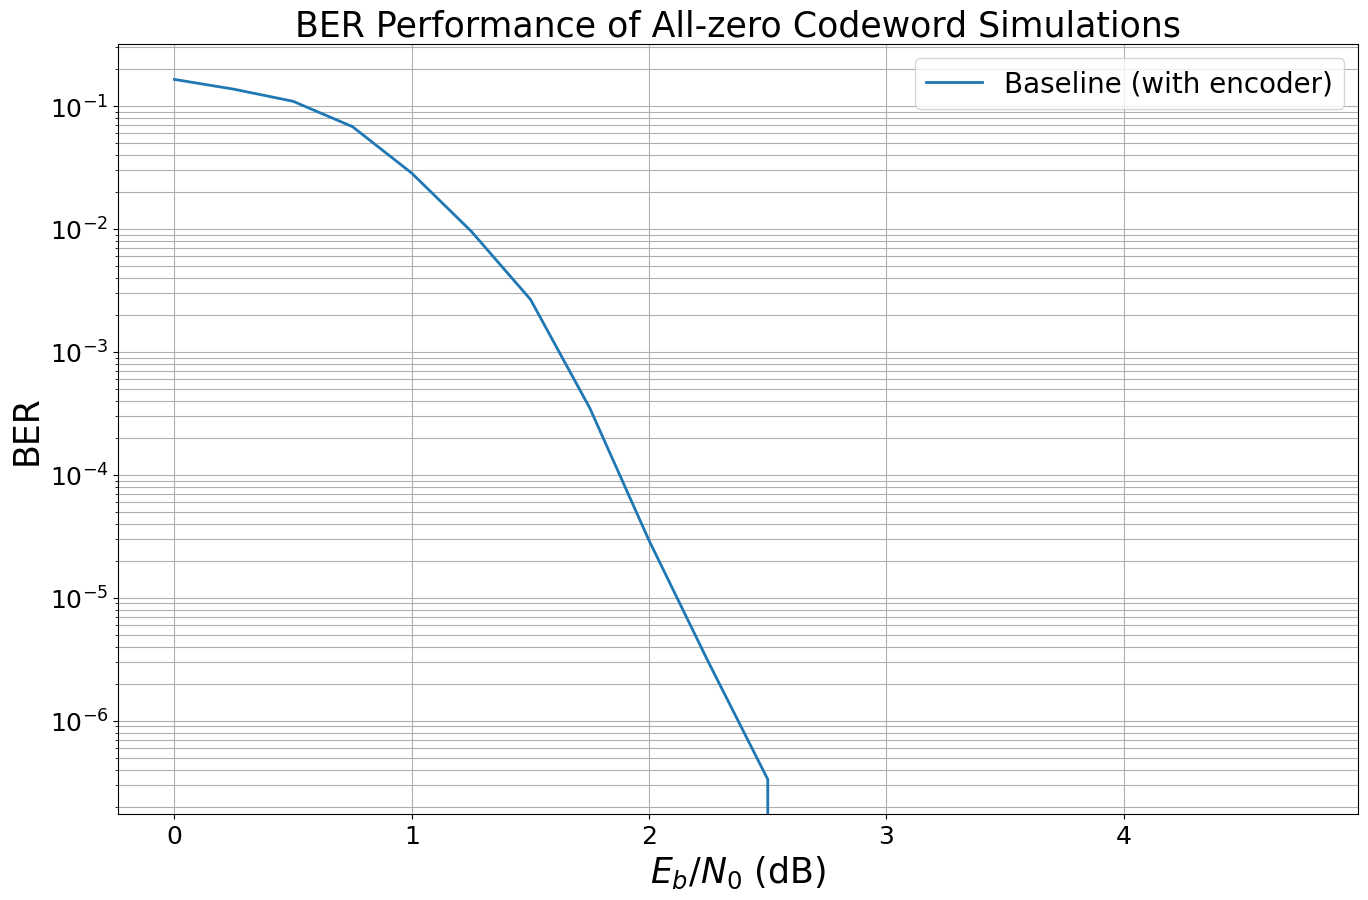

In [9]:
 # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
ber_plot_allzero.simulate(run_ber, # the function have defined previously
                          ebno_dbs=np.arange(0, 5, 0.25), # sim SNR range
                          legend="Baseline (with encoder)",
                          max_mc_iter=50,
                          num_target_bit_errors=1000,
                          batch_size=1000,
                          soft_estimates=False,
                          early_stop=True,
                          show_fig=True,
                          forward_keyboard_interrupt=False);

In 5G communications, zero codeword simulations are a specific testing approach used in channel coding and error correction verification. 

**Codeword Basics**
A codeword is a fixed-length sequence of bits transmitted in digital communication systems. In 5G, codewords are crucial for error detection and correction during data transmission[2].

**Zero Codeword Characteristics**
A zero codeword specifically refers to a transmission pattern where all bits are set to zero. While this might seem simplistic, it serves important diagnostic purposes in simulation:

- Helps validate basic error correction mechanisms
- Tests fundamental signal processing capabilities
- Provides a baseline performance benchmark

**Simulation Outcomes and Implications**
The expected outcomes of zero codeword simulations typically include:

- Verifying **error correction reliability**
- Assessing **signal processing integrity**
- Checking **channel coding performance**

**5G Specific Considerations**
In 5G networks, zero codeword simulations are particularly relevant for:

- Polar coding techniques
- Low-Density Parity Check (LDPC) code validation
- Performance evaluation of different channel models

**Potential Limitations**
However, zero codeword simulations have significant drawbacks:

- May not represent real-world data transmission scenarios
- Can potentially provide overly optimistic performance estimates
- Do not capture the complexity of diverse data patterns

Experts recommend complementing zero codeword simulations with more comprehensive testing approaches that simulate diverse, real24-1-21-1-5/5g-ldpc-simulation-results.html

In [12]:
### all zero codeward simulations
class LDPC_QAM_AWGN(tf.keras.Model):
    def __init__(self,
                 k,
                 n,
                 num_bits_per_symbol,
                 demapping_method='app',
                 decoder_type='boxplus',
                 use_allzeros=False,
                 use_scrambler=False,
                 use_ldpc_output_interleaver=False,
                 no_est_mismatch=1.):
        super().__init__()
        self.k = k
        self.n = n
        self.num_bits_per_symbol=num_bits_per_symbol
        self.use_allzeros=use_allzeros
        self.use_scrambler=use_scrambler
        self.no_est_mismatch=no_est_mismatch
        self.source = BinarySource()
        self.constellation = Constellation('qam', num_bits_per_symbol=self.num_bits_per_symbol)
        self.mapper = Mapper(constellation=constellation)
        self.demapper=Demapper(demapping_method, constellation=self.constellation)
        self.channel = AWGN()

        #ldpc encoder and decoder
        if use_ldpc_output_interleaver:# needs to know abt the modulation order
            self.encoder = LDPC5GEncoder(self.k, self.n, num_bits_per_symbol)
        else:
            self.encoder = LDPC5GEncoder(self.k, self.n)
        self.decoder=LDPC5GDecoder(self.encoder, cn_type = decoder_type)
        self.scrambler = Scrambler()
        self.descrambler = Descrambler(self.scrambler, binary=False)
    #graph mode for high tput 
    @tf.function()
    def call(self, batch_size, ebno_db):
        #noise variance
        no = ebnodb2no(ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=self.k/self.n)
        if self.use_allzeros:
            u = tf.zeros([batch_size, self.k]) 
            c = tf.zeros([batch_size, self.n])
        else:
            u = self.source([batch_size, self.k])
            c = self.encoder(u)
        # scrabler if req
        if self.use_scrambler:
            c = self.scrambler(c)
        x = self.mapper(c) #map c symbols
        y = self.channel([x, no])
        # add noise estimation mismatch for demapper
        no_est = no * self.no_est_mismatch
        llr_ch = self.demapper([y, no_est])

        if self.use_scrambler:
            llr_ch = self.descrambler(llr_ch)
        u_hat = self.decoder(llr_ch)
        return u, u_hat
        
        

**Scrambler and Descrambler in 5G Communication**

**Scrambling Fundamentals**
Scrambling is a critical process in 5G networks that transforms transmitted data to improve security and communication efficiency. It involves modifying information bits before transmission to make signals appear random and prevent unauthorized access[1].

**Key Characteristics**
- Transforms original data without changing bit rate
- Uses bitwise operations (typically XOR)
- Applies unique scrambling codes based on Radio Network Temporary Identifier (RNTI)

**Mathematical Representation**
The scrambling process can be expressed as:
$$ S = D \text{ XOR } C $$
Where:
- S = Scrambled data
- D = Original data
- C = Scrambling code

**Operational Modes**

1. **Downlink Scrambling**
- Performed by gNB (base station)
- Uses RNTI-based scrambling code
- Applies code before transmission to specific User Equipment (UE)

2. **Uplink Scrambling**
- Executed by User Equipment
- Uses UE-specific scrambling code
- Ensures unique signal identification

**Purpose and Benefits**
- Enhances data security
- Reduces interference between different UEs
- Provides privacy protection
- Enables better signal synchronization

**Descrambling Process**
At the receiver side, descrambling involves:
- XORing received signal with original scrambling code
- Retrieving original data by reversing the scrambling operation

**Advantages**
- No data rate increase
- Eliminates long sequences of 0s and 1s
- Creates more signal transitions
- Supports synchronization

**Potential Limitations**
- Potential error multiplication in certain descrambling methods
- Requires precise synchronization
- May fail in extreme signal conditions

Scrambling remains a fundamental technique in 5G networks, ensuring secure and efficient data transmission

### **Scrambler and RNTI in 5G NR**

In 5G New Radio (NR), **scrambling** is a process used to randomize the transmitted data to make it appear noise-like and to reduce interference. The **Radio Network Temporary Identifier (RNTI)** plays a crucial role in the scrambling process for different types of physical channels and signals.

---

### **1. Scrambler in 5G NR**
A **scrambler** is a mathematical operation (bitwise XOR with a scrambling sequence) applied to data before modulation. It helps in:
- Randomizing data to avoid long sequences of identical bits.
- Reducing electromagnetic interference.
- Separating signals intended for different users or logical channels.

The scrambling sequence is pseudo-random and is generated using a **Gold sequence**, which depends on various parameters, including the RNTI.

#### **Scrambler Operation:**
\[
\text{Scrambled bits} = \text{Original bits} \oplus \text{Scrambling Sequence}
\]

---

### **2. Radio Network Temporary Identifier (RNTI)**
The **RNTI** is a unique identifier assigned to a UE (User Equipment) or a specific transmission in the network. It is used in the scrambling process to ensure that different users and logical channels have distinct scrambling sequences.

#### **Types of RNTI and Their Usage:**
| **RNTI Type**  | **Usage** |
|---------------|----------|
| **C-RNTI (Cell RNTI)** | Identifies a specific UE in connected mode. |
| **RA-RNTI (Random Access RNTI)** | Used during Random Access Procedure. |
| **SI-RNTI (System Information RNTI)** | Used for broadcasting system information. |
| **P-RNTI (Paging RNTI)** | Used for paging messages. |
| **TC-RNTI (Temporary C-RNTI)** | Temporarily assigned to a UE before establishing a permanent C-RNTI. |
| **SP-CSI-RNTI (Semi-Persistent CSI RNTI)** | Used for periodic CSI reports. |

---

### **3. How RNTI is Used in Scrambling**
- The scrambling sequence is generated using a **pseudo-random sequence generator**, which takes **RNTI and other parameters (e.g., slot number, cell ID)** as input.
- This ensures that different UEs, logical channels, or transmissions do not interfere with each other.
- Example: **Downlink PDSCH (Physical Downlink Shared Channel) scrambling sequence** is initialized with:
  \[
  c(n) = x_1(n + N_{ID}) \oplus x_2(n + N_{ID})
  \]
  where \( N_{ID} \) includes the **RNTI and cell ID**.

---

### **Summary**
- **Scrambling** is used in 5G to randomize data for improved performance and reduced interference.
- **RNTI** is a unique identifier assigned to UEs or logical transmissions, and it plays a key role in generating unique scrambling sequences.
- Each transmission type (e.g., system information, paging, user data) uses a different RNTI to maintain distinct communication channels.

Let me know if you need a deeper explanation! 🚀ttps://www.perfectjammer.com/cell-phone-scrambler-bypass.html

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.6465e-01 | 1.0000e+00 |       98792 |      600000 |         1000 |        1000 |         2.1 |reached target bit errors
     0.25 | 1.4058e-01 | 9.9600e-01 |       84345 |      600000 |          996 |        1000 |         1.2 |reached target bit errors
      0.5 | 1.0198e-01 | 9.2600e-01 |       61186 |      600000 |          926 |        1000 |         1.2 |reached target bit errors
     0.75 | 6.5198e-02 | 7.5900e-01 |       39119 |      600000 |          759 |        1000 |         1.2 |reached target bit errors
      1.0 | 3.2080e-02 | 4.9400e-01 |       19248 |      600000 |          494 |        1000 |         1.2 |reached target bit errors
     1.25 | 1.1087e-02 | 2.2800e-01 |        6652 |      600000 |          

(<tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([1.64653333e-01, 1.40575000e-01, 1.01976667e-01, 6.51983333e-02,
        3.20800000e-02, 1.10866667e-02, 2.58000000e-03, 4.19166667e-04,
        6.21604938e-05, 3.83333333e-06, 3.33333333e-08, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])>,
 <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([1.00000000e+00, 9.96000000e-01, 9.26000000e-01, 7.59000000e-01,
        4.94000000e-01, 2.28000000e-01, 6.80000000e-02, 1.30000000e-02,
        1.92592593e-03, 2.40000000e-04, 2.00000000e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])>)

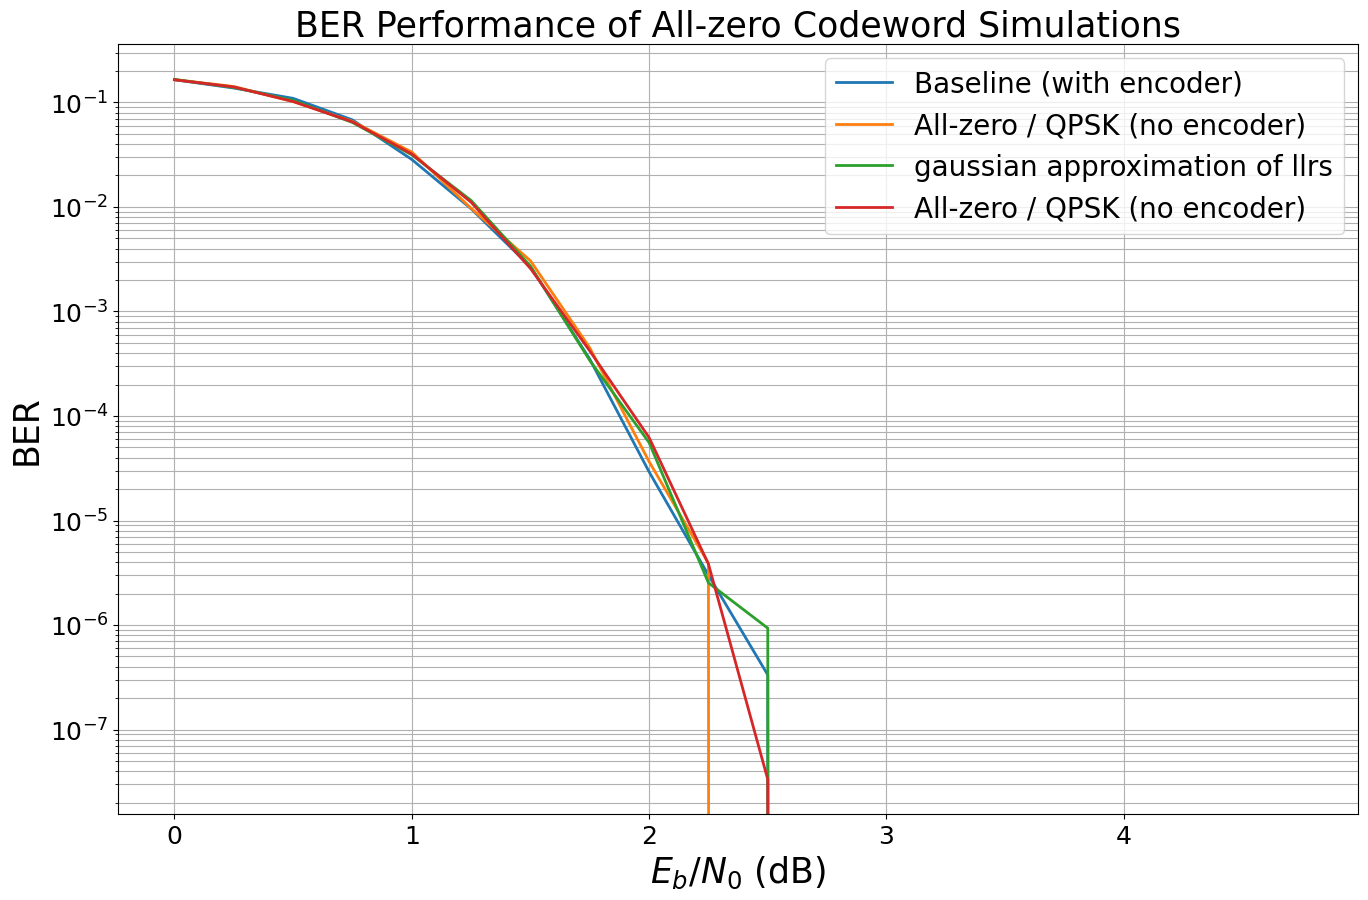

In [36]:
# simulating the QPSK with all 0 transmission 
model_allzero = LDPC_QAM_AWGN(k,
                           n,
                           num_bits_per_symbol=2,
                           use_allzeros=True,
                           use_scrambler=False)

ber_plot_allzero.simulate(model_allzero,
                          ebno_dbs=np.arange(0,5,0.25),
                          legend = 'All-zero / QPSK (no encoder)',
                          max_mc_iter=50,
                          num_target_bit_errors=1000,
                          batch_size=1000,
                          soft_estimates=False,
                          show_fig=True,
                          forward_keyboard_interrupt=False)
                      
                          

This statement describes an approach to **approximate the Log-Likelihood Ratio (LLR) distribution** of a **BPSK or QPSK** signal over an **Additive White Gaussian Noise (AWGN) channel**, specifically for the **all-zero codeword** case. Let's break it down step by step:

---

### **1. All-Zero Codeword and Mapping in BPSK**
- In **Binary Phase Shift Keying (BPSK)**, the standard mapping is:
  \[
  0 \rightarrow +1, \quad 1 \rightarrow -1
  \]
- When we assume an **all-zero codeword** (i.e., all transmitted bits are 0), every bit is mapped to **+1** in BPSK.
- Thus, the transmitted signal consists entirely of **+1 values**.

---

### **2. Effect of AWGN Channel**
- The **AWGN (Additive White Gaussian Noise) channel** introduces noise to the transmitted signal:
  \[
  y = x + n
  \]
  where:
  - \( x = +1 \) (since all-zero codeword maps to +1 in BPSK)
  - \( n \sim \mathcal{N}(0, \sigma^2) \) (Gaussian noise with zero mean and variance \( \sigma^2 \))
- Therefore, the received signal \( y \) follows a **Gaussian distribution**:
  \[
  y \sim \mathcal{N}(+1, \sigma^2)
  \]
  meaning \( y \) has a mean of **+1** and variance \( \sigma^2 \).

---

### **3. Demapping and LLR Computation**
- The demapper computes **Log-Likelihood Ratios (LLRs)**, which measure how confident the receiver is about whether a received bit was 0 or 1.
- The **LLR for BPSK** is computed as:
  \[
  LLR(y) = \log \left( \frac{P(y | x = +1)}{P(y | x = -1)} \right)
  \]
  - Since \( P(y | x = +1) \) and \( P(y | x = -1) \) are Gaussian probability densities, the LLR simplifies to:
  \[
  LLR(y) = \frac{2y}{\sigma^2}
  \]
- This LLR is also **Gaussian distributed** with:
  - Mean: \( \frac{2 \cdot 1}{\sigma^2} = \frac{2}{\sigma^2} \)
  - Variance: \( \frac{4\sigma^2}{\sigma^4} = \frac{4}{\sigma^2} \)

Thus, the **LLR follows a Gaussian distribution** with:
\[
LLR \sim \mathcal{N} \left(\frac{2}{\sigma^2}, \frac{4}{\sigma^2} \right)
\]

- This means we can model the combined effects of:
  - **BPSK mapping**
  - **AWGN channel**
  - **LLR computation**
  using a **Gaussian source**, which simplifies simulations.

---

### **4. Extending to QPSK**
- The same reasoning applies to **Quadrature Phase Shift Keying (QPSK)**, where two bits are mapped to a complex symbol.
- Each real and imaginary component behaves like an independent BPSK system.
- Thus, the LLRs for QPSK components follow the same Gaussian distribution structure.

---

### **5. Monte Carlo Verification**
- To **validate** the theoretical Gaussian approximation, a **Monte Carlo simulation** can be run:
  1. Generate random noise samples from \( \mathcal{N}(0, \sigma^2) \).
  2. Compute received symbols \( y = x + n \).
  3. Compute LLRs using \( LLR(y) = \frac{2y}{\sigma^2} \).
  4. Verify if the empirical distribution of LLRs matches the predicted Gaussian distribution.

---

### **6. Sign Convention in LLR Computation**
- The **negative sign** mentioned in the statement refers to a **difference in how LLRs are defined**.
- In some communications contexts, the LLR is defined as:
  \[
  LLR(y) = \log \left( \frac{P(y | x = -1)}{P(y | x = +1)} \right)
  \]
  which is the **inverse** of the conventional LLR definition.
- This reversal results in a **negative sign difference** when computing LLRs, but the statistical properties remain unchanged.

---

### **Conclusion**
This approach allows us to **approximate the effects of modulation, channel noise, and demapping** using a simple Gaussian model. This is useful for simulations where we need to generate synthetic LLR values without explicitly simulating the full transmission process.

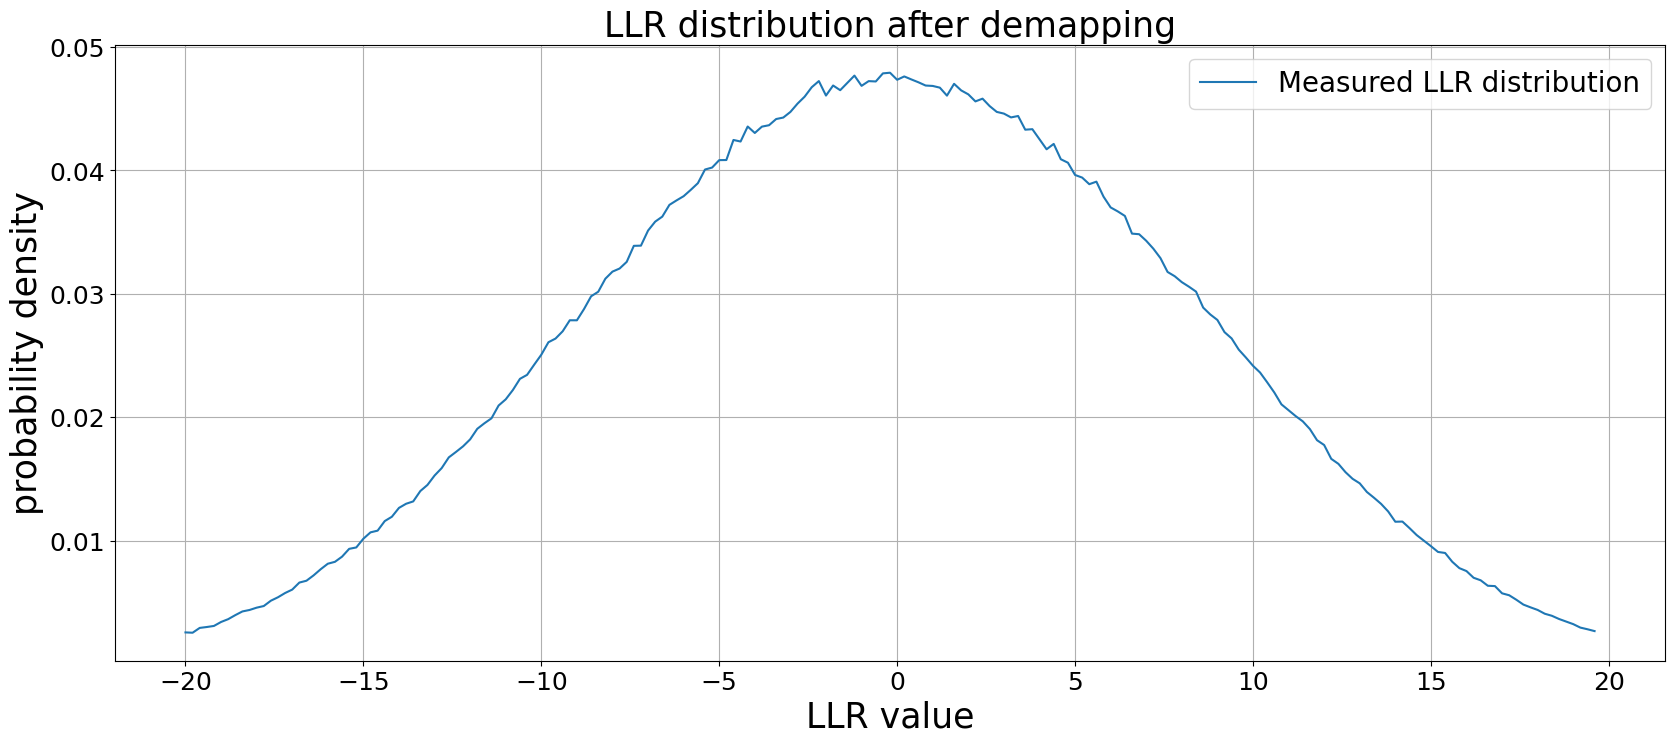

In [18]:
num_bits_per_symbol = 2 #qpsk
ebno_db = 4
batch_size = 100000
no = ebnodb2no(ebno_db, num_bits_per_symbol=num_bits_per_symbol, coderate=k/n)
#bins for hist
llr_bins = np.arange(-20, 20, 0.2)
c = tf.zeros([batch_size, num_bits_per_symbol])
x = mapper(c)
y = channel([y ,no])
llr = demapper([y, no])
llr_dist,  _ = np.histogram(llr.numpy(), bins=llr_bins, density=True)
#negative logit
mu_llr = -2 / no
no_llr = 4 / no

#gaussian PDF
llr_pred = 1/np.sqrt(2*np.pi*no_llr) * np.exp(-(llr_bins-mu_llr) ** 2/(2*no_llr))

#comparing the results
plt.figure(figsize=(20,8))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='both')
plt.xlabel('LLR value', fontsize=25)
plt.ylabel('probability density', fontsize=25)
plt.plot(llr_bins[:-1], llr_dist, label='Measured LLR distribution')
plt.title('LLR distribution after demapping', fontsize=25)
plt.legend(fontsize=20)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.6596e-01 | 9.9900e-01 |       99574 |      600000 |          999 |        1000 |         2.7 |reached target bit errors
     0.25 | 1.3904e-01 | 9.9300e-01 |       83422 |      600000 |          993 |        1000 |         2.0 |reached target bit errors
      0.5 | 1.0456e-01 | 9.4400e-01 |       62738 |      600000 |          944 |        1000 |         1.9 |reached target bit errors
     0.75 | 6.4265e-02 | 7.4500e-01 |       38559 |      600000 |          745 |        1000 |         1.8 |reached target bit errors
      1.0 | 3.1535e-02 | 4.7600e-01 |       18921 |      600000 |          476 |        1000 |         1.8 |reached target bit errors
     1.25 | 1.1532e-02 | 2.2100e-01 |        6919 |      600000 |          

(<tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([1.65956667e-01, 1.39036667e-01, 1.04563333e-01, 6.42650000e-02,
        3.15350000e-02, 1.15316667e-02, 2.71666667e-03, 3.39666667e-04,
        5.55555556e-05, 2.53333333e-06, 9.33333333e-07, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])>,
 <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([9.99000000e-01, 9.93000000e-01, 9.44000000e-01, 7.45000000e-01,
        4.76000000e-01, 2.21000000e-01, 6.40000000e-02, 1.18000000e-02,
        1.93333333e-03, 1.40000000e-04, 2.00000000e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])>)

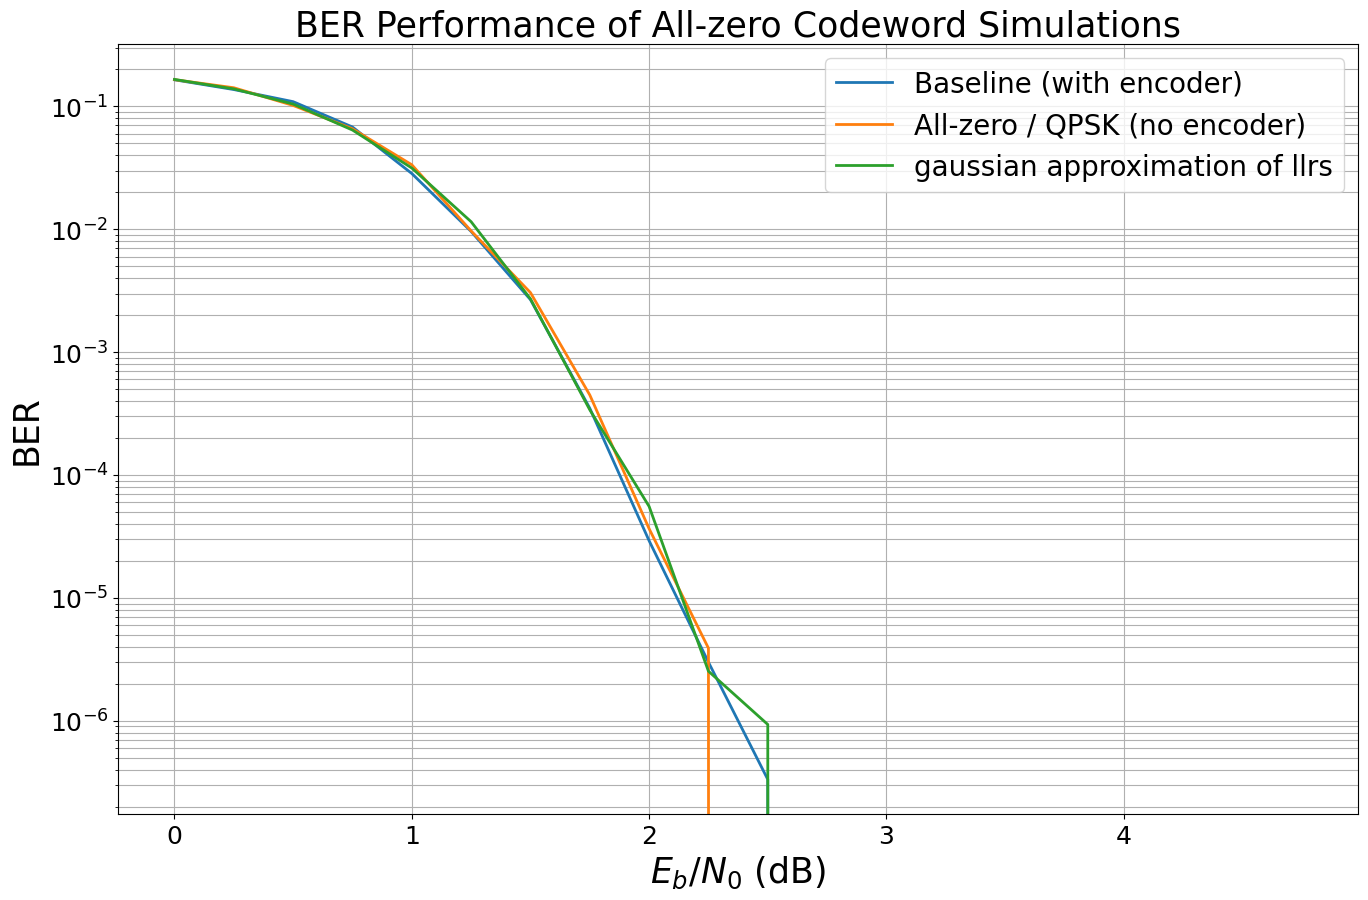

In [25]:
num_bits_per_symbol = 2 
ga_source = GaussianPriorSource()
@tf.function()
def run_ber_ga(batch_size, ebno_db):
    no = ebnodb2no(ebno_db, num_bits_per_symbol=num_bits_per_symbol, coderate=k/n)
    u = tf.zeros([batch_size, k])
    llr_ch = ga_source([[batch_size, n], no]) #gen llrs directly 
    u_hat = decoder(llr_ch)
    return u, u_hat

#simulating the new curev

ber_plot_allzero.simulate(run_ber_ga,
                          ebno_dbs=np.arange(0,5,0.25),
                          max_mc_iter=50,
                          num_target_bit_errors=1000,
                          legend = 'gaussian approximation of llrs',
                          batch_size=1000,
                          soft_estimates=False,
                          show_fig=True,
                          forward_keyboard_interrupt=False)


In [27]:
# here is the hero , the scrambler
ber_plot_allzero16qam = PlotBER('ber performance for 64 QAM')

In [35]:
# simulate a new baseline for 16-QAM
model_baseline_16 = LDPC_QAM_AWGN(k,
                                  n,
                                  num_bits_per_symbol=4,
                                  use_allzeros=False, # baseline without all-zero
                                  use_scrambler=False)


# and simulate the new curve
# Hint: as the model is callable, we can directly pass it to the
# Monte Carlo simulation
ber_plot_allzero16qam.simulate(model_baseline_16,
                               ebno_dbs=np.arange(0, 5, 0.25),
                               legend="Baseline 16-QAM",
                               max_mc_iter=50,
                               num_target_bit_errors=2000,
                               batch_size=1000,
                               soft_estimates=False,
                               show_fig=True,
                               forward_keyboard_interrupt=False);

AssertionError: Exception encountered when calling layer 'ldpc_qam_awgn_6' (type LDPC_QAM_AWGN).

in user code:

    File "C:\Users\DELL\AppData\Local\Temp\ipykernel_4452\1194785548.py", line 56, in call  *
        u_hat = self.decoder(llr_ch)
    File "C:\Users\DELL\anaconda3\envs\sionna_env\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\DELL\anaconda3\envs\sionna_env\lib\site-packages\sionna\fec\ldpc\decoding.py", line 1246, in build
        assert (input_shape[-1]==self.encoder.n), \

    AssertionError: Last dimension must be of length n.


Call arguments received by layer 'ldpc_qam_awgn_6' (type LDPC_QAM_AWGN):
  • batch_size=tf.Tensor(shape=(), dtype=int32)
  • ebno_db=tf.Tensor(shape=(), dtype=float32)